# Predictions from Click Patterns

### import modules

In [1]:
import pickle

import glob
import re

import numpy as np
import pandas as pd
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

### get data

In [2]:
cond_df = pd.read_csv('../data/interim/lofi_Lower_CUTUP_flat_df.tsv', sep='\t', index_col=[0, 1, 2, 3])

In [3]:
cond_df

0  1  2  3  4  5  6  7  8  9  ...  14510  \
Angry     Angry     AF01 p001  0  0  0  0  0  0  0  0  0  0  ...      0   
                         p002  0  0  0  0  0  0  0  0  0  0  ...      0   
                         p003  0  0  0  0  0  0  0  0  0  0  ...      0   
                         p004  0  0  0  0  0  0  0  0  0  0  ...      0   
                         p005  0  0  0  0  0  0  0  0  0  0  ...      0   
...                           .. .. .. .. .. .. .. .. .. ..  ...    ...   
Surprised Surprised AM32 p228  0  0  0  0  0  0  0  0  0  0  ...      0   
                         p230  0  0  0  0  0  0  0  0  0  0  ...      0   
                         p231  0  0  0  0  0  0  0  0  0  0  ...      0   
                         p232  0  0  0  0  0  0  0  0  0  0  ...      0   
                         p233  0  0  0  0  0  0  0  0  0  0  ...      0   

                               14511  14512  14513  14514  14515  14516  \
Angry     Angry     AF01 p001      0      0      0      0      0      0   
                         p002      0      0      0      0      0      0   
                         p003      0      0      0      0      0      0   
                         p004      0      0      0      0      0      0   
                         p005      0      0      0      0      0      0   
...                              ...    ...    ...    ...    ...    ...   
Surprised Surprised AM32 p228      0      0      0      0      0      0   
                         p230      0      0      0      0      0      0   
                         p231      0      0      0      0      0      0   
                         p232      0      0      0      0      0      0   
                         p233      0      0      0      0      0      0   

                               14517  14518  14519  
Angry     Angry     AF01 p001      0      0      0  
                         p002      0      0      0  
                         p003      0      0      0  
                         p004      0      0      0  
                         p005      0      0      0  
...                              ...    ...    ...  
Surprised Surprised AM32 p228      0      0      0  
                         p230      0      0      0  
                         p231      0      0      0  
                         p232      0      0      0  
                         p233      0      0      0  

[14140 rows x 14520 columns]

Number of rows and columns?

In [4]:
cond_df.shape

(14140, 14520)

How many million datapoints?

In [5]:
cond_df.shape[0] * cond_df.shape[1] / 1000000

205.3128

### example participant

In [6]:
target_p = 'p002'

#### get participant data

The ```p_df``` are the data of the selected participant, the ```mean_df``` are the data of all other participants, averaged. We can now try to use the group average as a template and try to compare the different conditions of the target (held-out) participant with the group average by correlations, with the participant data being assigned the label of the group condition with which the correlate the most (winner-take-all).

In [7]:
p_df = cond_df.xs(target_p, level=3)
p_df.tail()

0  1  2  3  4  5  6  7  8  9  ...  14510  14511  \
Surprised Surprised AM02  0  0  0  0  0  0  0  0  0  0  ...      0      0   
                    AM04  0  0  0  0  0  0  0  0  0  0  ...      0      0   
                    AM06  0  0  0  0  0  0  0  0  0  0  ...      0      0   
                    AM23  0  0  0  0  0  0  0  0  0  0  ...      0      0   
                    AM32  0  0  0  0  0  0  0  0  0  0  ...      0      0   

                          14512  14513  14514  14515  14516  14517  14518  \
Surprised Surprised AM02      0      0      0      0      0      0      0   
                    AM04      0      0      0      0      0      0      0   
                    AM06      0      0      0      0      0      0      0   
                    AM23      0      0      0      0      0      0      0   
                    AM32      0      0      0      0      0      0      0   

                          14519  
Surprised Surprised AM02      0  
                    AM04      0  
                    AM06      0  
                    AM23      0  
                    AM32      0  

[5 rows x 14520 columns]

#### get all other data

In [8]:
template_df = cond_df.drop(target_p, level=3)
mean_df = template_df.groupby(level=[0, 1]).mean()
mean_df.tail()

0    1    2    3    4    5    6    7    8    9  ...  \
Surprised Disgusted  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
          Fearful    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
          Happy      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
          Sad        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
          Surprised  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

                     14510  14511  14512  14513  14514  14515  14516  14517  \
Surprised Disgusted    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
          Fearful      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
          Happy        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
          Sad          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
          Surprised    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                     14518  14519  
Surprised Disgusted    0.0    0.0  
          Fearful      0.0    0.0  
          Happy        0.0    0.0  
          Sad          0.0    0.0  
          Surprised    0.0    0.0  

[5 rows x 14520 columns]

In [9]:
mean_df.max().max()

1.0

### correlate group data with held-out participant

In [10]:
def make_corr_df(p_df, mean_df):
    
    corr_dict = {}
    
    for i in tqdm(p_df.index, leave=False):
        
        this_series = p_df.loc[i, :]
        this_corr = mean_df.T.corrwith(this_series)
        corr_dict[i] = this_corr
        
    p_corr_df = pd.DataFrame(corr_dict).T
    
    return p_corr_df

In [11]:
p_corr_df = make_corr_df(p_df, mean_df)

  0%|          | 0/70 [00:00<?, ?it/s]

In [17]:
p_corr_df.loc['Surprised']

Angry                                                    \
                   Angry Disgusted   Fearful     Happy       Sad Surprised   
Surprised AF01  0.547668  0.372680  0.439437 -0.003194  0.489729  0.262108   
          AF05  0.581493  0.423159  0.529894  0.080639  0.517385  0.262057   
          AF07  0.589409  0.278030  0.396524  0.410652  0.317977  0.076366   
          AF14  0.399595  0.354092  0.386232  0.273066  0.394682  0.149819   
          AF30  0.580027  0.438302  0.545136  0.239045  0.484096  0.212112   
          AM02  0.354778  0.433331  0.466048  0.041325  0.519705  0.301891   
          AM04  0.513616  0.395748  0.417367  0.134742  0.474335  0.185874   
          AM06  0.574064  0.416294  0.517337  0.062670  0.521529  0.276113   
          AM23       NaN       NaN       NaN       NaN       NaN       NaN   
          AM32  0.433851  0.449898  0.507539  0.005987  0.551014  0.367457   

               Disgusted                                ...       Sad  \
                   Angry Disgusted   Fearful       Sad  ...   Fearful   
Surprised AF01  0.546395  0.583454  0.519686  0.573975  ...  0.581573   
          AF05  0.421872  0.475419  0.448976  0.517630  ...  0.592668   
          AF07  0.377438  0.376598  0.377373  0.378816  ...  0.507000   
          AF14  0.127157  0.187215  0.180428  0.248181  ...  0.359676   
          AF30  0.317899  0.373569  0.356374  0.431260  ...  0.549380   
          AM02  0.117128  0.181177  0.190934  0.257390  ...  0.372297   
          AM04  0.278439  0.350242  0.326403  0.412097  ...  0.494385   
          AM06  0.419617  0.477792  0.458003  0.526343  ...  0.590645   
          AM23       NaN       NaN       NaN       NaN  ...       NaN   
          AM32  0.253231  0.301744  0.303290  0.355163  ...  0.455631   

                                             Surprised                      \
                 Neutral       Sad Surprised     Angry Disgusted   Fearful   
Surprised AF01  0.775407  0.655307  0.489660  0.355345  0.381320  0.293376   
          AF05  0.662327  0.639930  0.401753  0.532114  0.481081  0.406643   
          AF07  0.441485  0.450321  0.373852  0.623874  0.790828  0.654549   
          AF14  0.375809  0.381531  0.097057  0.640893  0.563244  0.489366   
          AF30  0.541464  0.568814  0.345951  0.689418  0.629920  0.532276   
          AM02  0.358241  0.392310  0.089805  0.511326  0.341750  0.304513   
          AM04  0.599476  0.531184  0.225331  0.615891  0.639186  0.456423   
          AM06  0.660428  0.639993  0.416688  0.507046  0.471078  0.382660   
          AM23       NaN       NaN       NaN       NaN       NaN       NaN   
          AM32  0.480467  0.486975  0.201844  0.363280  0.301367  0.300219   

                                              
                   Happy       Sad Surprised  
Surprised AF01  0.484809  0.376111  0.346075  
          AF05  0.517816  0.419430  0.443933  
          AF07  0.455681  0.665505  0.625892  
          AF14  0.352457  0.544614  0.401552  
          AF30  0.510249  0.502443  0.532383  
          AM02  0.352992  0.327509  0.294001  
          AM04  0.432552  0.585958  0.417527  
          AM06  0.534971  0.391039  0.430122  
          AM23       NaN       NaN       NaN  
          AM32  0.392577  0.352807  0.319274  

[10 rows x 40 columns]

### use labels of highest correlation as winner-take-all prediction

In [12]:
def make_pred_df(p_corr_df, im_pred=False):
    
    pred_df = pd.DataFrame(p_corr_df.idxmax(axis=1))
    pred_df.columns = ['predicted']
    
    if im_pred:
        pred_df.loc[:, 'true'] = [i for i in pred_df.index]      
        
    else:
        pred_df.loc[:, 'true'] = [(i[0], i[1]) for i in pred_df.index]
    
    return pred_df

In [13]:
pred_df = make_pred_df(p_corr_df)
pred_df

predicted                    true
Angry     Angry     AF01        (Neutral, Angry)          (Angry, Angry)
                    AF05  (Surprised, Disgusted)          (Angry, Angry)
                    AF07      (Surprised, Happy)          (Angry, Angry)
                    AF14          (Angry, Angry)          (Angry, Angry)
                    AF30        (Neutral, Angry)          (Angry, Angry)
...                                          ...                     ...
Surprised Surprised AM02            (Angry, Sad)  (Surprised, Surprised)
                    AM04  (Surprised, Disgusted)  (Surprised, Surprised)
                    AM06        (Neutral, Angry)  (Surprised, Surprised)
                    AM23                     NaN  (Surprised, Surprised)
                    AM32            (Angry, Sad)  (Surprised, Surprised)

[70 rows x 2 columns]

In [15]:
pred_df.loc['Surprised']

predicted                    true
Surprised AF01          (Sad, Neutral)  (Surprised, Surprised)
          AF05        (Neutral, Angry)  (Surprised, Surprised)
          AF07  (Surprised, Disgusted)  (Surprised, Surprised)
          AF14      (Surprised, Angry)  (Surprised, Surprised)
          AF30      (Surprised, Angry)  (Surprised, Surprised)
          AM02            (Angry, Sad)  (Surprised, Surprised)
          AM04  (Surprised, Disgusted)  (Surprised, Surprised)
          AM06        (Neutral, Angry)  (Surprised, Surprised)
          AM23                     NaN  (Surprised, Surprised)
          AM32            (Angry, Sad)  (Surprised, Surprised)

### make held-out WTA predictions for all participants

In [14]:
def make_big_pred_df(cond_df, im_pred=False, my_level=3):
    
    big_pred_df = pd.DataFrame()

    for target_p in tqdm(cond_df.index.levels[my_level], leave=False):

        # get participant
        p_df = cond_df.xs(target_p, level=my_level)

        # get average of all others
        template_df = cond_df.drop(target_p, level=my_level)
        
        # this has to be adjusted when we use images instead of real answers
        if my_level == 1:    
            mean_df = template_df.groupby(level=[0]).mean()
        else:
            mean_df = template_df.groupby(level=[0, 1]).mean()
            
        # correlate
        p_corr_df = make_corr_df(p_df, mean_df)

        # predict based on biggest correlation
        pred_df = make_pred_df(p_corr_df, im_pred=im_pred)
        
        # reshape
        pred_df = pred_df.drop('true', axis=1).T # true is redundant???
        pred_df.index = [target_p]
        
        big_pred_df = pd.concat([big_pred_df, pred_df])
        
    return big_pred_df

In [15]:
big_pred_df = make_big_pred_df(cond_df)

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

In [16]:
big_pred_df.tail()

Angry                                              \
                       Angry                                               
                        AF01                AF05                    AF07   
p228        (Neutral, Happy)                 NaN        (Neutral, Angry)   
p230  (Surprised, Surprised)  (Neutral, Neutral)          (Angry, Happy)   
p231  (Surprised, Disgusted)  (Surprised, Angry)        (Fearful, Angry)   
p232      (Fearful, Neutral)                 NaN  (Surprised, Surprised)   
p233                     NaN                 NaN                     NaN   

                                                                        \
                                                                         
                      AF14                    AF30                AM02   
p228  (Fearful, Disgusted)            (Sad, Angry)                 NaN   
p230    (Fearful, Neutral)  (Surprised, Surprised)  (Fearful, Neutral)   
p231        (Neutral, Sad)            (Angry, Sad)        (Sad, Angry)   
p232    (Angry, Surprised)                     NaN    (Neutral, Angry)   
p233                   NaN          (Angry, Happy)                 NaN   

                                                                      \
                                                                       
                  AM04                    AM06                  AM23   
p228  (Sad, Disgusted)          (Sad, Neutral)        (Sad, Neutral)   
p230               NaN  (Surprised, Surprised)        (Angry, Happy)   
p231      (Angry, Sad)          (Sad, Neutral)    (Fearful, Neutral)   
p232        (Sad, Sad)          (Angry, Happy)  (Fearful, Disgusted)   
p233               NaN                     NaN    (Disgusted, Angry)   

                              ... Fearful       Sad Angry            \
                              ...   Angry Surprised Happy Disgusted   
                        AM32  ...    AF14      AF01  AF05      AF07   
p228                     NaN  ...     NaN       NaN   NaN       NaN   
p230      (Happy, Surprised)  ...     NaN       NaN   NaN       NaN   
p231  (Surprised, Disgusted)  ...     NaN       NaN   NaN       NaN   
p232    (Fearful, Surprised)  ...     NaN       NaN   NaN       NaN   
p233                     NaN  ...     NaN       NaN   NaN       NaN   

                 Sad                                 Fearful         Neutral  \
               Angry Surprised       Fearful       Disgusted           Angry   
                AF30      AF05          AM02            AM06            AM06   
p228             NaN       NaN           NaN             NaN             NaN   
p230             NaN       NaN           NaN             NaN             NaN   
p231             NaN       NaN           NaN             NaN             NaN   
p232             NaN       NaN  (Sad, Angry)             NaN             NaN   
p233  (Sad, Neutral)       NaN           NaN  (Sad, Neutral)  (Sad, Neutral)   

                 Surprised  
                     Happy  
                      AF05  
p228                   NaN  
p230                   NaN  
p231                   NaN  
p232                   NaN  
p233  (Surprised, Fearful)  

[5 rows x 233 columns]

### do this for all masking conditions

In [17]:
big_pred_df = pd.DataFrame()

for cond in tqdm(['Full', 'Lower', 'Upper']):

    file = f'../data/interim/lofi_{cond}_CUTUP_flat_df.tsv'
    cond_df = pd.read_csv(file, sep='\t', index_col=[0, 1, 2, 3])
    
    cond_pred_df = make_big_pred_df(cond_df)
    cond_pred_df.columns = pd.MultiIndex.from_tuples([(cond, c[0], c[1], c[2]) for c in cond_pred_df.columns])
    
    big_pred_df = pd.concat([big_pred_df, cond_pred_df], axis=1)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

In [18]:
big_pred_df

Full                                                \
                       Angry                                                 
                       Angry                                                 
                        AF01                    AF05                  AF07   
p001        (Fearful, Angry)          (Neutral, Sad)        (Angry, Angry)   
p002  (Disgusted, Surprised)  (Surprised, Disgusted)      (Neutral, Angry)   
p003          (Angry, Angry)          (Angry, Angry)      (Neutral, Angry)   
p004          (Angry, Angry)          (Angry, Angry)        (Angry, Angry)   
p005  (Disgusted, Disgusted)        (Fearful, Angry)        (Angry, Angry)   
...                      ...                     ...                   ...   
p228    (Fearful, Disgusted)        (Fearful, Angry)      (Neutral, Angry)   
p230  (Surprised, Surprised)      (Neutral, Neutral)  (Surprised, Fearful)   
p231          (Angry, Angry)          (Angry, Angry)        (Angry, Angry)   
p232          (Angry, Angry)                     NaN        (Angry, Angry)   
p233          (Happy, Happy)        (Fearful, Angry)        (Angry, Angry)   

                                                                          \
                                                                           
                                                                           
                    AF14                    AF30                    AM02   
p001    (Neutral, Angry)        (Angry, Fearful)        (Neutral, Angry)   
p002      (Neutral, Sad)          (Sad, Neutral)          (Sad, Neutral)   
p003  (Angry, Surprised)            (Angry, Sad)        (Neutral, Angry)   
p004        (Angry, Sad)      (Angry, Disgusted)            (Angry, Sad)   
p005      (Angry, Angry)                     NaN          (Angry, Angry)   
...                  ...                     ...                     ...   
p228      (Angry, Angry)              (Sad, Sad)      (Neutral, Fearful)   
p230    (Fearful, Angry)  (Surprised, Surprised)  (Surprised, Surprised)   
p231    (Angry, Fearful)            (Angry, Sad)  (Disgusted, Surprised)   
p232      (Angry, Angry)        (Fearful, Angry)          (Angry, Angry)   
p233      (Angry, Angry)          (Angry, Happy)          (Angry, Angry)   

                                                                    \
                                                                     
                                                                     
                  AM04                    AM06                AM23   
p001    (Neutral, Sad)          (Angry, Angry)  (Disgusted, Angry)   
p002      (Angry, Sad)          (Neutral, Sad)      (Sad, Neutral)   
p003               NaN            (Angry, Sad)      (Angry, Angry)   
p004    (Angry, Angry)      (Angry, Surprised)  (Disgusted, Angry)   
p005    (Angry, Angry)        (Angry, Fearful)      (Angry, Angry)   
...                ...                     ...                 ...   
p228  (Sad, Disgusted)        (Neutral, Angry)    (Fearful, Angry)   
p230               NaN    (Surprised, Fearful)  (Fearful, Fearful)   
p231      (Angry, Sad)  (Disgusted, Surprised)      (Angry, Angry)   
p232      (Angry, Sad)          (Angry, Angry)      (Angry, Angry)   
p233    (Angry, Angry)          (Neutral, Sad)  (Neutral, Neutral)   

                            ...   Upper                            \
                            ... Fearful       Sad Angry             
                            ...   Angry Surprised Happy Disgusted   
                      AM32  ...    AF14      AF01  AF05      AF07   
p001        (Angry, Angry)  ...     NaN       NaN   NaN       NaN   
p002        (Sad, Neutral)  ...     NaN       NaN   NaN       NaN   
p003        (Angry, Angry)  ...     NaN       NaN   NaN       NaN   
p004        (Angry, Angry)  ...     NaN       NaN   NaN       NaN   
p005      (Disgusted, Sad)  ...     NaN       NaN   NaN       NaN   
...                    ...  ...     ... 

#### store

In [19]:
big_pred_df.to_csv('../data/processed/big_pred_CUTUP_df.tsv', sep='\t')

## Make accuracies

### for predicting true image label from click pattern

In [20]:
def make_acc_df(big_pred_df, pos):    
    
    im_ans_df = big_pred_df.applymap(lambda x:x[pos] if x==x else x)
    acc_df = im_ans_df==im_ans_df.apply(lambda x:x.name[pos])
    acc_df = acc_df.groupby(level=[0, 1], axis=1).sum()
    
    return acc_df

In [21]:
im_acc_df = make_acc_df(big_pred_df.loc[:, 'Full'], 0)
im_acc_df.tail()

Angry                                       Disgusted                    \
     Angry Disgusted Fearful Happy Sad Surprised     Angry Disgusted Fearful   
p228     1         0       0     0   0         0         1         2       0   
p230     0         0       0     0   0         0         0         0       0   
p231     7         0       0     0   0         0         0         4       0   
p232     8         0       0     0   1         0         0         4       1   
p233     5         0       0     0   0         0         0         4       0   

          ...     Sad                       Surprised                          \
     Sad  ... Fearful Neutral Sad Surprised     Angry Disgusted Fearful Happy   
p228   1  ...       1       0   6         0         0         0       0     1   
p230   0  ...       0       0   0         0         0         0       1     0   
p231   0  ...       0       0   4         0         0         0       0     0   
p232   0  ...       2       0   2         0         0         0       0     0   
p233   1  ...       0       0   1         0         0         0       0     1   

                    
     Sad Surprised  
p228   0         9  
p230   0         8  
p231   0         5  
p232   0        10  
p233   0         5  

[5 rows x 40 columns]

### do this for all masking conditions

In [22]:
def make_big_acc_df(big_pred_df, pos):

    big_acc_df = pd.DataFrame()

    for c in big_pred_df.columns.levels[0]:

        this_pred_df = big_pred_df.loc[:, c]
        this_acc_df = make_acc_df(this_pred_df, pos)
        
        this_acc_df.columns = pd.MultiIndex.from_tuples([(c, i[0], i[1]) for i in this_acc_df.columns])

        big_acc_df = pd.concat([big_acc_df, this_acc_df], axis=1)

    big_acc_df = big_acc_df/10
    
    return big_acc_df

### For images

In [23]:
big_im_acc_df = make_big_acc_df(big_pred_df, 0)
big_im_acc_df.tail()

Full                                                                     \
     Angry                                        Disgusted                     
     Angry Disgusted Fearful Happy  Sad Surprised     Angry Disgusted Fearful   
p228   0.1       0.0     0.0   0.0  0.0       0.0       0.1       0.2     0.0   
p230   0.0       0.0     0.0   0.0  0.0       0.0       0.0       0.0     0.0   
p231   0.7       0.0     0.0   0.0  0.0       0.0       0.0       0.4     0.0   
p232   0.8       0.0     0.0   0.0  0.1       0.0       0.0       0.4     0.1   
p233   0.5       0.0     0.0   0.0  0.0       0.0       0.0       0.4     0.0   

           ...   Upper                                                     \
           ...     Sad                        Surprised                     
      Sad  ... Fearful Neutral  Sad Surprised     Angry Disgusted Fearful   
p228  0.1  ...     0.1     0.0  0.3       0.0       0.0       0.0     0.0   
p230  0.0  ...     0.0     0.0  0.2       0.0       0.0       0.0     0.0   
p231  0.0  ...     0.0     0.0  0.2       0.0       0.0       0.0     0.0   
p232  0.0  ...     0.1     0.0  0.3       0.0       0.0       0.0     0.0   
p233  0.1  ...     0.0     0.0  0.0       0.0       0.0       0.0     0.0   

                           
                           
     Happy  Sad Surprised  
p228   0.1  0.0       0.7  
p230   0.0  0.0       0.1  
p231   0.0  0.0       0.6  
p232   0.0  0.0       0.8  
p233   0.0  0.0       0.1  

[5 rows x 120 columns]

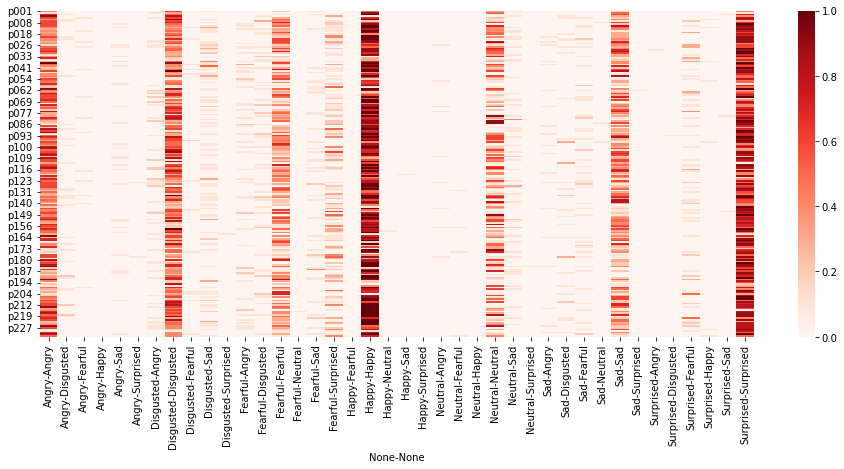

In [24]:
plt.figure(figsize=(16, 6))
sns.heatmap( big_im_acc_df.loc[:, 'Full'], cmap='Reds' )
plt.show()

#### store for re-use

In [25]:
big_im_acc_df.to_csv('../data/processed/big_im_CUTUP_acc_df.tsv', sep='\t')

### For predicting participants' answers (instead of true image labels)

In [26]:
big_ans_acc_df = make_big_acc_df(big_pred_df, 1)
big_ans_acc_df.tail()

Full                                                                     \
     Angry                                        Disgusted                     
     Angry Disgusted Fearful Happy  Sad Surprised     Angry Disgusted Fearful   
p228   0.6       0.0     0.0   0.0  0.0       0.0       0.0       0.3     0.0   
p230   0.1       0.0     0.1   0.0  0.0       0.0       0.0       0.0     0.0   
p231   0.5       0.0     0.0   0.0  0.0       0.0       0.0       0.1     0.0   
p232   0.8       0.0     0.0   0.0  0.0       0.0       0.0       0.0     0.0   
p233   0.6       0.0     0.0   0.0  0.0       0.0       0.0       0.2     0.0   

           ...   Upper                                                     \
           ...     Sad                        Surprised                     
      Sad  ... Fearful Neutral  Sad Surprised     Angry Disgusted Fearful   
p228  0.0  ...     0.1     0.0  0.1       0.0       0.0       0.0     0.0   
p230  0.0  ...     0.1     0.0  0.0       0.0       0.0       0.0     0.0   
p231  0.1  ...     0.0     0.0  0.1       0.0       0.0       0.0     0.0   
p232  0.0  ...     0.1     0.0  0.2       0.0       0.0       0.0     0.0   
p233  0.0  ...     0.0     0.0  0.0       0.0       0.0       0.0     0.0   

                           
                           
     Happy  Sad Surprised  
p228   0.0  0.0       0.3  
p230   0.0  0.0       0.2  
p231   0.0  0.0       0.5  
p232   0.0  0.0       0.6  
p233   0.0  0.0       0.3  

[5 rows x 120 columns]

In [27]:
big_ans_acc_df = make_big_acc_df(big_pred_df, 1)
big_ans_acc_df.tail()

Full                                                                     \
     Angry                                        Disgusted                     
     Angry Disgusted Fearful Happy  Sad Surprised     Angry Disgusted Fearful   
p228   0.6       0.0     0.0   0.0  0.0       0.0       0.0       0.3     0.0   
p230   0.1       0.0     0.1   0.0  0.0       0.0       0.0       0.0     0.0   
p231   0.5       0.0     0.0   0.0  0.0       0.0       0.0       0.1     0.0   
p232   0.8       0.0     0.0   0.0  0.0       0.0       0.0       0.0     0.0   
p233   0.6       0.0     0.0   0.0  0.0       0.0       0.0       0.2     0.0   

           ...   Upper                                                     \
           ...     Sad                        Surprised                     
      Sad  ... Fearful Neutral  Sad Surprised     Angry Disgusted Fearful   
p228  0.0  ...     0.1     0.0  0.1       0.0       0.0       0.0     0.0   
p230  0.0  ...     0.1     0.0  0.0       0.0       0.0       0.0     0.0   
p231  0.1  ...     0.0     0.0  0.1       0.0       0.0       0.0     0.0   
p232  0.0  ...     0.1     0.0  0.2       0.0       0.0       0.0     0.0   
p233  0.0  ...     0.0     0.0  0.0       0.0       0.0       0.0     0.0   

                           
                           
     Happy  Sad Surprised  
p228   0.0  0.0       0.3  
p230   0.0  0.0       0.2  
p231   0.0  0.0       0.5  
p232   0.0  0.0       0.6  
p233   0.0  0.0       0.3  

[5 rows x 120 columns]

In [28]:
big_ans_acc_df.to_csv('../data/processed/big_ans_CUTUP_acc_df.tsv', sep='\t')

## With Pixel Values of Images

### make predictions

In [29]:
def make_ims_pred_df(file_name):

    img_df = pd.read_csv(file_name, sep='\t', index_col=[0, 1, 2])
    conds = img_df.index.levels[0]

    biggest_pred_df = pd.DataFrame()
    
    for cond in tqdm(conds):
        
        full_df = img_df.loc[cond, :]
        
        big_pred_df = make_big_pred_df(full_df, im_pred=True, my_level=1)
        big_pred_df.columns = pd.MultiIndex.from_tuples([(cond, i) for i in big_pred_df.columns])

        biggest_pred_df = pd.concat([biggest_pred_df, big_pred_df], axis=1)

    biggest_pred_df = biggest_pred_df.sort_index(axis=1)
    
    return biggest_pred_df

### for all masking conditions

There are three maskings:

* lofi: no masking but downsampled to deal with memory limitations
* cropped: square mask
* masked: only pixels into which participants clicked

In [30]:
file_list = glob.glob('../data/interim/img_*_df.tsv')
file_list

['../data/interim/img_cropped_df.tsv',
 '../data/interim/img_masked_df.tsv',
 '../data/interim/img_lofi_df.tsv']

In [31]:
im_pred_df = pd.DataFrame()

regex = re.compile(r'.*img_(\w+)_df.*')
for file in tqdm(file_list):

    mask_name = regex.findall(file)[-1]
    mask_name = 'Image ' + mask_name[0].upper() + mask_name[1:]
    
    this_pred_df = make_ims_pred_df(file)
    this_pred_df.columns = pd.MultiIndex.from_tuples([(mask_name, i[0], i[1]) for i in this_pred_df.columns])

    im_pred_df = pd.concat([im_pred_df, this_pred_df], axis=1)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [32]:
im_pred_df.tail()

Image Cropped                                                         \
              Full                                                          
             Angry  Disgusted    Fearful      Happy    Neutral        Sad   
AM02         Angry  Disgusted  Surprised      Happy  Surprised    Neutral   
AM04     Disgusted  Disgusted    Fearful  Disgusted    Fearful    Fearful   
AM06         Angry    Neutral  Surprised      Happy      Angry      Angry   
AM23       Fearful    Fearful    Fearful    Fearful    Fearful    Fearful   
AM32         Angry  Surprised    Neutral      Happy  Surprised  Surprised   

                                                  ... Image Lofi             \
                     Lower                        ...      Lower              
      Surprised      Angry  Disgusted    Fearful  ...    Neutral        Sad   
AM02  Surprised  Surprised  Disgusted  Surprised  ...  Surprised  Disgusted   
AM04  Surprised      Angry  Surprised    Fearful  ...  Surprised      Angry   
AM06      Angry      Angry    Fearful    Fearful  ...    Fearful  Surprised   
AM23    Fearful    Fearful  Disgusted  Surprised  ...  Surprised  Surprised   
AM32  Surprised      Angry  Disgusted    Fearful  ...      Angry      Angry   

                                                                      \
                   Upper                                               
      Surprised    Angry  Disgusted    Fearful      Happy    Neutral   
AM02  Surprised    Happy  Disgusted      Happy      Happy      Happy   
AM04  Surprised    Angry  Disgusted    Fearful  Disgusted  Disgusted   
AM06  Surprised    Angry      Angry      Angry      Angry      Angry   
AM23  Surprised  Fearful  Disgusted    Fearful    Fearful    Fearful   
AM32  Surprised    Angry  Disgusted  Surprised      Angry      Angry   

                            
                            
            Sad  Surprised  
AM02  Disgusted      Happy  
AM04        Sad  Disgusted  
AM06      Angry      Angry  
AM23  Disgusted    Fearful  
AM32      Angry  Surprised  

[5 rows x 63 columns]

In [33]:
im_pred_df.to_csv('../data/processed/im_pred_df.tsv', sep='\t')

### accuracies for image-based predictions

In [34]:
im_acc_df = im_pred_df==im_pred_df.apply(lambda x:x.name[2])
im_acc_df.tail()

Image Cropped                                                           \
              Full                                                    Lower   
             Angry Disgusted Fearful  Happy Neutral    Sad Surprised  Angry   
AM02          True      True   False   True   False  False      True  False   
AM04         False      True    True  False   False  False      True   True   
AM06          True     False   False   True   False  False     False   True   
AM23         False     False    True  False   False  False     False  False   
AM32          True     False   False   True   False  False      True   True   

                        ... Image Lofi                                    \
                        ...      Lower                   Upper             
     Disgusted Fearful  ...    Neutral    Sad Surprised  Angry Disgusted   
AM02      True   False  ...      False  False      True  False      True   
AM04     False    True  ...      False  False      True   True      True   
AM06     False    True  ...      False  False      True   True     False   
AM23      True   False  ...      False  False      True  False      True   
AM32      True    True  ...      False  False      True   True      True   

                                              
                                              
     Fearful  Happy Neutral    Sad Surprised  
AM02   False   True   False  False     False  
AM04    True  False   False   True     False  
AM06   False  False   False  False     False  
AM23    True  False   False  False     False  
AM32   False  False   False  False      True  

[5 rows x 63 columns]

In [35]:
im_acc_df.to_csv('../data/processed/im_acc_df.tsv', sep='\t')

## Combine Tables

#### click patterns for true image

In [36]:
click_im_acc_df = big_im_acc_df.groupby(level=[0, 1], axis=1).sum()
click_im_acc_df.columns = pd.MultiIndex.from_tuples([('Click-Im', i[0], i[1]) for i in click_im_acc_df.columns])
click_im_acc_df.tail()

Click-Im                                                                 \
         Full                                                Lower             
        Angry Disgusted Fearful Happy Neutral  Sad Surprised Angry Disgusted   
p228      0.1       0.4     0.7   0.8     0.3  0.7       1.0   0.0       0.5   
p230      0.0       0.0     0.2   0.1     0.0  0.0       0.9   0.2       0.0   
p231      0.7       0.4     0.1   0.8     0.1  0.6       0.5   0.2       0.2   
p232      0.9       0.5     0.6   1.0     0.2  0.4       1.0   0.2       0.1   
p233      0.5       0.5     0.5   0.7     0.5  0.1       0.6   0.1       0.1   

              ...                                                       \
              ...                        Upper                           
     Fearful  ... Neutral  Sad Surprised Angry Disgusted Fearful Happy   
p228     0.2  ...     0.1  0.4       0.5   0.3       0.3     0.5   0.4   
p230     0.2  ...     0.0  0.0       0.4   0.0       0.0     0.1   0.3   
p231     0.0  ...     0.3  0.3       0.6   0.4       0.5     0.0   0.8   
p232     0.4  ...     0.1  0.2       0.3   1.0       0.5     0.2   0.4   
p233     0.1  ...     0.1  0.1       0.5   0.3       0.4     0.2   0.5   

                             
                             
     Neutral  Sad Surprised  
p228     0.3  0.4       0.8  
p230     0.6  0.2       0.1  
p231     0.2  0.2       0.6  
p232     0.3  0.4       0.8  
p233     0.2  0.0       0.1  

[5 rows x 21 columns]

#### click patterns for answers

In [37]:
click_ans_acc_df = big_ans_acc_df.groupby(level=[0, 1], axis=1).sum()
click_ans_acc_df.columns = pd.MultiIndex.from_tuples([('Click-Ans', i[0], i[1]) for i in click_ans_acc_df.columns])
click_ans_acc_df.tail()

Click-Ans                                                                 \
          Full                                                Lower             
         Angry Disgusted Fearful Happy Neutral  Sad Surprised Angry Disgusted   
p228       0.6       0.3     0.4   0.7     0.3  0.4       0.3   0.2       0.2   
p230       0.2       0.0     0.5   0.1     0.1  0.1       0.3   0.0       0.0   
p231       0.5       0.2     0.1   0.7     0.2  0.2       0.3   0.3       0.1   
p232       0.8       0.0     0.4   0.8     0.0  0.7       0.9   0.1       0.0   
p233       0.6       0.2     0.3   0.7     0.2  0.1       0.5   0.1       0.0   

              ...                                                       \
              ...                        Upper                           
     Fearful  ... Neutral  Sad Surprised Angry Disgusted Fearful Happy   
p228     0.0  ...     0.1  0.1       0.2   0.5       0.2     0.3   0.4   
p230     0.0  ...     0.3  0.0       0.3   0.2       0.1     0.3   0.4   
p231     0.0  ...     0.5  0.1       0.1   0.5       0.0     0.3   0.7   
p232     0.1  ...     0.5  0.1       0.4   0.3       0.0     0.1   0.2   
p233     0.2  ...     0.2  0.1       0.1   0.1       0.2     0.3   0.4   

                             
                             
     Neutral  Sad Surprised  
p228     0.1  0.2       0.3  
p230     0.3  0.1       0.2  
p231     0.1  0.1       0.5  
p232     0.0  0.3       0.6  
p233     0.0  0.0       0.3  

[5 rows x 21 columns]

### other data

#### emotion label answers

In [38]:
ans_df = pd.read_csv('../data/processed/big_correct_df.tsv', sep='\t', index_col=[0], header=[0, 1])
ans_df.columns = pd.MultiIndex.from_tuples([('Answer', i[0], i[1]) for i in ans_df.columns])
ans_df.tail()

Answer                                                                 \
       Full                                                Lower             
      Angry Disgusted Fearful Happy Neutral  Sad Surprised Angry Disgusted   
p228    1.0       0.5     0.4   1.0     0.7  0.9       0.9   0.6       0.7   
p230    0.9       0.9     0.5   1.0     0.8  0.9       0.9   0.7       0.7   
p231    1.0       0.8     0.9   1.0     0.7  0.6       1.0   0.3       1.0   
p232    0.9       0.6     0.4   1.0     0.9  0.6       1.0   0.7       0.9   
p233    1.0       0.9     0.2   1.0     0.6  0.8       0.9   0.1       0.5   

              ...                                                       \
              ...                        Upper                           
     Fearful  ... Neutral  Sad Surprised Angry Disgusted Fearful Happy   
p228     0.1  ...     0.6  0.7       0.8   0.9       0.3     0.5   0.8   
p230     0.4  ...     1.0  0.7       0.7   0.9       0.3     0.6   0.9   
p231     0.7  ...     0.9  0.7       0.8   0.9       0.2     0.2   0.9   
p232     0.1  ...     0.9  0.7       0.9   0.9       0.3     0.4   0.9   
p233     0.0  ...     0.7  0.1       0.9   1.0       0.2     0.3   0.9   

                             
                             
     Neutral  Sad Surprised  
p228     0.4  0.8       0.7  
p230     0.9  0.8       0.9  
p231     0.8  0.3       1.0  
p232     0.5  0.7       0.9  
p233     0.8  0.5       0.9  

[5 rows x 21 columns]

#### image predictions

In [39]:
im_acc_df.tail()

Image Cropped                                                           \
              Full                                                    Lower   
             Angry Disgusted Fearful  Happy Neutral    Sad Surprised  Angry   
AM02          True      True   False   True   False  False      True  False   
AM04         False      True    True  False   False  False      True   True   
AM06          True     False   False   True   False  False     False   True   
AM23         False     False    True  False   False  False     False  False   
AM32          True     False   False   True   False  False      True   True   

                        ... Image Lofi                                    \
                        ...      Lower                   Upper             
     Disgusted Fearful  ...    Neutral    Sad Surprised  Angry Disgusted   
AM02      True   False  ...      False  False      True  False      True   
AM04     False    True  ...      False  False      True   True      True   
AM06     False    True  ...      False  False      True   True     False   
AM23      True   False  ...      False  False      True  False      True   
AM32      True    True  ...      False  False      True   True      True   

                                              
                                              
     Fearful  Happy Neutral    Sad Surprised  
AM02   False   True   False  False     False  
AM04    True  False   False   True     False  
AM06   False  False   False  False     False  
AM23    True  False   False  False     False  
AM32   False  False   False  False      True  

[5 rows x 63 columns]

### combine

In [40]:
merge_df = pd.concat([ans_df, click_im_acc_df, click_ans_acc_df, im_acc_df], axis=1)
merge_df.to_csv('../data/processed/acc_merge_df.tsv', sep='\t')